In [1]:
pip show qutip

Name: qutip
Version: 5.0.4
Summary: QuTiP: The Quantum Toolbox in Python
Home-page: https://qutip.org
Author: Alexander Pitchford, Paul D. Nation, Robert J. Johansson, Chris Granade, Arne Grimsmo, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguere, Boxi Li, Jake Lishman, Simon Cross
Author-email: qutip-admin@googlegroups.com
License: BSD 3-Clause License
Location: /Users/dev/anaconda3/lib/python3.11/site-packages
Requires: numpy, packaging, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In this notebook, we will compute the following Quantum Speed limit for the Tranverse Field Ising Model

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmaz, sigmay, qeye, mesolve, ptrace, thermal_dm, Qobj
from qutip import*
from pylab import*
from scipy import integrate

The Hamiltonian of our simple spin chain system is :
$$ 
H = -J \sum_{i} \sigma_{i}^{z} \sigma_{i+1}^{z} - h \sum_{i} \sigma_{i}^{x} - g \sum_{i} \sigma_{i}^{z}
$$

In [14]:
def spin_chain_ham(h,g,J,N):
    sx = [tensor([sigmax() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    sy = [tensor([sigmay() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    sz = [tensor([sigmaz() if i == j else qeye(2) for i in range(N)]) for j in range(N)]

    # Construct the Ising Hamiltonian for the full system (N spins)
    H_full = sum(-J * sz[i] * sz[i + 1] for i in range(N - 1)) - sum(h * sx[i] for i in range(N)) - sum(g * sz[i] for i in range(N))
    return H_full

Renyi entropy is defined as :
$$
S_{A}^{2}(t) = \frac{1}{1-\alpha}\log{tr\rho_{A}(t)^{\alpha}}
$$
where
$$
\rho_{A}(t) = tr_{B}\rho_{AB}(t)\
$$

In [15]:
def renyi_entropy_manual(rho, alpha):
    rho_alpha = rho ** alpha  # Compute rho^alpha
    trace_rho_alpha = np.real(rho_alpha.tr())# Trace of rho^alpha
    
    return (1 / (1 - alpha)) * np.log(trace_rho_alpha)


def renyi_entropy_list(time_evol_result, alpha):
    renyi_entropy_list = []
    for rho_t in time_evol_result.states:
 
        reduced_rho = ptrace(rho_t, [0])
       # Compute Renyi entropy (order 2)
        renyi_entropy = renyi_entropy_manual(reduced_rho, alpha)
        renyi_entropy_list.append(renyi_entropy)
     
    
    return renyi_entropy_list


    

We need operators time evolved in the Heisenberg picture to compute two time correlation functions:
$$
A(t) = e^{iHt}A(0)e^{-iHt}
$$

In [16]:
def heisenberg_time_evolution(H, A, time):
    
        # Calculate the time-evolution operator U(t)
    U_t = propagator(H, time)  # U(t) = exp(-i H t)
        
        # Evolve the operator in the Heisenberg picture: A(t) = U^\dagger A U
    A_t_at_time_t = U_t.dag() * A * U_t
        
        # Append the expectation value of the evolved operator at time t
    
    
    return A_t_at_time_t

Two time correlation function for two operators wrt a state is given by:
$$
tr( A(t_{1})B(t_{2})\rho)
$$

In [17]:
def twopt_2t(H, psi0, A, B, t1, t2):
    A_t1 = heisenberg_time_evolution(H, A, t1)
    B_t2 = heisenberg_time_evolution(H, B, t2)
    corr = (A_t1*B_t2*psi0).tr()
    
    return corr

In [18]:
def rel_ent(rho,sigma):
    return (rho*rho.logm() - rho*sigma.logm()).tr()

In [19]:
# Parameters
N = 4      # Number of spins (total system)
J = 1.0      # Interaction strength
h = 2.1
g = 1.1# Transverse field
beta = 1.0   # Inverse teerature (1/kT)
tlist = np.linspace(0, 4.0,25)  # Time evolutio
alpha = 2    # Order of Renyi entropy 

The system's hamiltonian is:
$$
H_{S} = -h\sigma_{1}^{z}-g\sigma_{1}^{x}
$$

The bath hamiltonian is:
$$
H_{B} = -J\sum_{i=2}^{N-1}\sigma_{i}^{z}\sigma_{i+1}^{z} - h\sum_{i=2}^{N}\sigma_{i}^{x} - g\sum_{i=2}^{N}\sigma_{i}^{x}
$$

The interaction Hamiltonian is :
$$
H_{I} = J\sigma_{1}^{z}\sigma_{2}^{z}
$$

The initial state of the system and bath is :
$$
\rho(0) = \rho_{S}\otimes\rho_{B}^{\beta}
$$

We perform a quench:
$$
\rho(0)\rightarrow O\rho(0)O^{\dagger}
$$

Time evolved quenched renyi entropy is computed for the state

$$
\rho_{A}(t) = tr_{B}(U^{\dagger}(t)O\rho(0)O^{\dagger}U(t))
$$



/var/folders/rn/51w2pjhj1kqdh6yq8s18zh440000gq/T/ipykernel_490/3617432575.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  H_full = sum(-J * sz[i] * sz[i + 1] for i in range(N - 1)) - sum(h * sx[i] for i in range(N)) - sum(g * sz[i] for i in range(N))


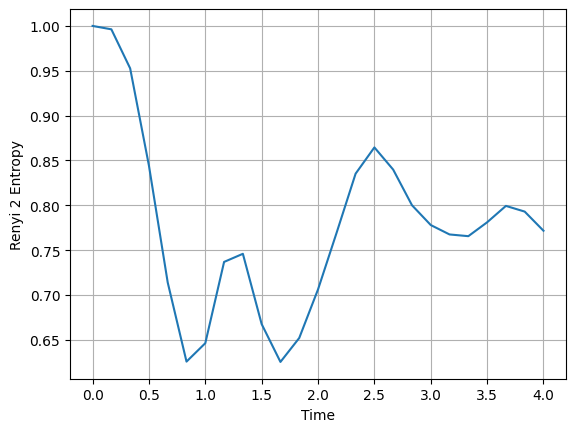

In [20]:

#create hamiltonian for system+bath consisiting of N spins 
H_full = spin_chain_ham(h,g,J,N)    

#create hamiltonian for bath consisting of N-1 spins
H_rest = spin_chain_ham(h,g,J,N-1)

H_0 = tensor(-h * sigmax(), *[qeye(2) for _ in range(N-1)])+ tensor(-g * sigmaz(), *[qeye(2) for _ in range(N-1)])

# Thermal state for the bath
#thermal_state_rest = (-beta * H_rest).expm() / (-beta * H_rest).expm().tr() 
thermal_state_rest = (-beta * H_rest).expm() / (-beta * H_rest).expm().tr() 

thermal_state_full = (-beta * H_full).expm() / (-beta * H_full).expm().tr()
#system spin in |0><0| 
pure_state_0 = basis(2, 0) * basis(2, 0).dag()

# Quench: apply sigma_x on the first spin
O = tensor(sigmax(), *[qeye(2) for _ in range(N-1)]) # sigma_y on the first spin, identity on the rest



#initial quenched state
initial_state = O*tensor(pure_state_0, thermal_state_rest)*O.dag()




class InteractionPictureResult:
    def __init__(self, states):
        self.states = states  # A list of states at each time

def int_pic_evolve(H, H0, time_list, initial_state):
    states = []  # List to store evolved states at each time

    # Loop over each time point in time_list
    for t in time_list:
        # Compute the propagators for H0 and H at time t
        U0 = propagator(H0, t)
        U = propagator(H, t)

        # Calculate the state in the interaction picture at time t
        prop_int_pic = U0.dag() * U
        evolved_state = prop_int_pic * initial_state * prop_int_pic.dag()

        # Append the evolved state to the states list
        states.append(evolved_state)

    # Return a custom result object with a .states attribute
    return InteractionPictureResult(states)


#obtain time evolved states
#result = mesolve(H_full, initial_state, tlist, [])

# Evolve each state from `result` in the interaction picture using `H_0`
result = int_pic_evolve(H_full, H_0, tlist, initial_state)



#compute renyi entropy at all times
renyi_entropy = renyi_entropy_list(result, alpha)



#plot renyi entropy vs time 

plt.plot(tlist,np.exp(-np.array(renyi_entropy)))
plt.xlabel('Time')
plt.ylabel(f'Renyi {alpha} Entropy')
#plt.title(f'Renyi {alpha} Entropy vs Time')
plt.grid(True)
#plt.savefig('Renyi 2 entropy long time.pdf')
plt.show()



We compute the two time non-homogeneous bath correlation function
$$
tr(\sigma_{2}^{z}(t)\sigma_{2}^{z}(s)\rho_{B}(t))
$$

where 
$$
\rho_{B}(t) = tr_{A}(U^{\dagger}(t)O\rho(0)O^{\dagger}U(t))
$$

/var/folders/rn/51w2pjhj1kqdh6yq8s18zh440000gq/T/ipykernel_490/189638354.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


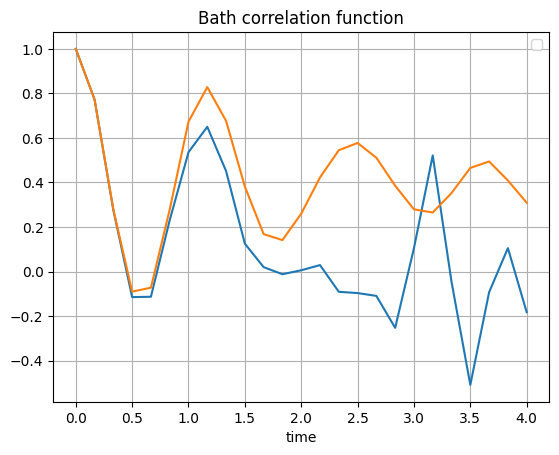

In [21]:

"""
bath_op = tensor(sigmaz(), *[qeye(2) for _ in range(N-2)]) 
corr =[]
thermal_corr =[]
for i in range(0,len(tlist)):
    rho_t = result.states[i]
    
    t = tlist[i]
    rho_bath = ptrace(rho_t,[i for i in range(1,N)])
    corr.append(np.real(twopt_2t(H_rest, rho_bath, bath_op, bath_op,t, 0)))
    thermal_corr.append(np.real(twopt_2t(H_rest, thermal_state_rest, bath_op, bath_op,t, 0)))
    #corr.append(np.real(rel_ent(thermal_state_rest, rho_bath)))
   




plt.plot(tlist,corr)
plt.plot(tlist,thermal_corr)
plt.grid()
plt.title('Bath correlation function')
plt.xlabel('time')
plt.legend()
#plt.savefig('bath corr meeting.pdf')
"""

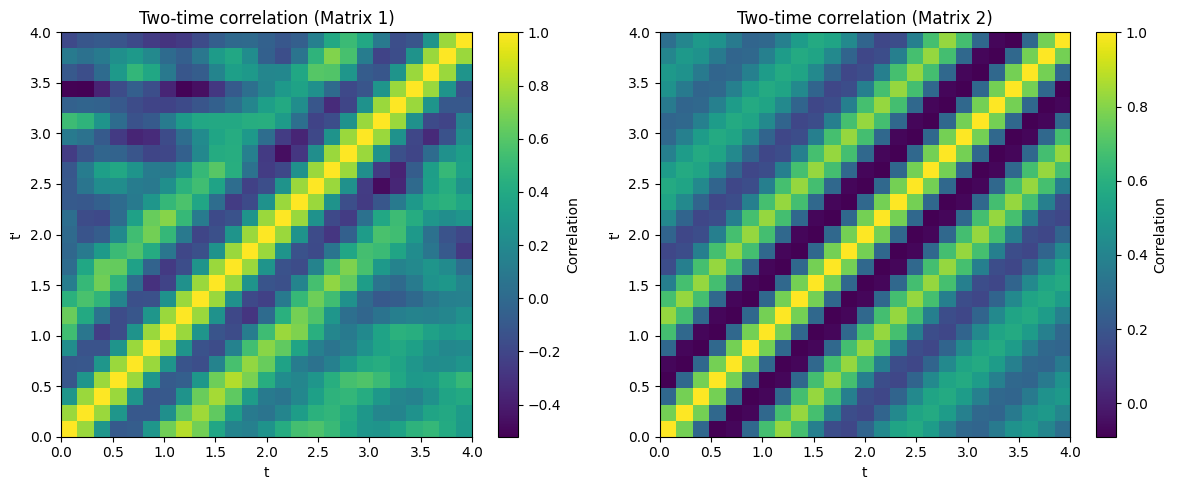

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the correlation matrix
N_time = len(tlist)
corr_matrix = np.zeros((N_time, N_time))
thermal_corr_matrix = np.zeros((N_time, N_time))

# Loop through each time pair and compute the two-time correlation
for i in range(N_time):
    rho_t = result.states[i]
    t = tlist[i]
    rho_bath = ptrace(rho_t, [i for i in range(1, N)])  # Partial trace to get the bath state
    
    for j in range(N_time):
        t_prime = tlist[j]
        # Compute the two-time correlation for each (t, t_prime) pair
        corr_matrix[i, j] = np.real(twopt_2t(H_rest, rho_bath, bath_op, bath_op, t, t_prime))
        thermal_corr_matrix[i, j] = np.real(twopt_2t(H_rest, thermal_state_rest, bath_op, bath_op, t, t_prime))

# Plot the correlation matrix as a colormap
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first imshow plot in the first subplot
im1 = axes[0].imshow(corr_matrix, aspect='auto', origin='lower', extent=[tlist[0], tlist[-1], tlist[0], tlist[-1]])
axes[0].set_title('Two-time correlation (Matrix 1)')
axes[0].set_xlabel('t')
axes[0].set_ylabel("t'")
fig.colorbar(im1, ax=axes[0], label='Correlation')

# Plot the second imshow plot in the second subplot
im2 = axes[1].imshow(thermal_corr_matrix, aspect='auto', origin='lower', extent=[tlist[0], tlist[-1], tlist[0], tlist[-1]])
axes[1].set_title('Two-time correlation (Matrix 2)')
axes[1].set_xlabel('t')
axes[1].set_ylabel("t'")
fig.colorbar(im2, ax=axes[1], label='Correlation')

# Display the figure
plt.tight_layout()  # Adjust layout to make room for colorbars
plt.show()


We define a function that computes the integrand on the RHS of the QSL:
$$
4J^{2}\Re{\langle \sigma_{2}^{z}(t') \sigma_{2}^{z}(s)\rangle_{\rho_{B}} }\lVert\sigma_{1}^{2}(t')\rVert\lVert\sigma_{1}^{2}(s)\rVert
$$

We perform the nested integral:
$$
4J^{2}\int_{0}^{t}dt'\int_{0}^{t'}ds \Re{\langle \sigma_{2}^{z}(t') \sigma_{2}^{z}(s)\rangle_{\rho_{B}} }\lVert\sigma_{1}^{2}(t')\rVert\lVert\sigma_{1}^{2}(s)\rVert
$$

In [24]:
  

def redfield_bound(t, H_bath, init_state, A, B, H0):
    
    def integrand(t_prime, s, H, psi0, A, B, H0):
    
        twopt_value = np.real(twopt_2t(H, psi0, A, B, t_prime, s))
    
    
        sigz_t1 = np.linalg.norm(heisenberg_time_evolution(H0, sigmaz(), t_prime).full(), 'fro')
        sigz_t2 = np.linalg.norm(heisenberg_time_evolution(H0, sigmaz(), s).full(), 'fro')
    
        norm_term = sigz_t1 * sigz_t2
    
       # Return the value for the integrand
        return 4 * (J**2) * twopt_value * norm_term
    # Define the lambda function for dblquad with only two variables of integration
    f = lambda y, x: integrand(y, x, H_bath, init_state, A, B, H0)
    
    # Perform the double integration
    return integrate.dblquad(f, 0, t, lambda x: 0, lambda x: x)



In [25]:
H_sys = -h * sigmax() -g * sigmaz()
bound = []
born_bound = []
for i in range(0,len(tlist)):
    rho_t = result.states[i]
    t = tlist[i]
    
    rho_bath = ptrace(rho_t,[i for i in range(1,N)])
   
    
    red_bound = redfield_bound(t, H_rest, rho_bath, bath_op,bath_op, H_sys)[0]
    print(i)
    
    bound.append(red_bound)
    
    red_born_bound = redfield_bound(t, H_rest, thermal_state_rest ,bath_op,bath_op, H_sys)[0]
    born_bound.append(red_born_bound)
                
                 
plt.plot(tlist,bound, label='Redfield bound')
plt.plot(tlist, renyi_entropy,label = 'Quenched Renyi Entropy')
plt.xlabel('time')
plt.title(r'QSL for $H = J\sum_{i}\sigma_{i}^{z}\sigma_{i+1}^{z}+h\sum_{i}\sigma_{i}^{x}$ with $N=4, J=1.0, h=0.8, \beta=1.0$')

plt.legend()
#plt.savefig('QSL spin chain.pdf')
plt.grid()
plt.show()

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


ValueError: 
QSL for $H = J\sum_{i}\sigma_{i}^{z}\sigma_{i+1}^{z}+h\sum_{i}\sigma_{i}^{x}$ with $N=4, J=1.0, h=0.8, eta=1.0$
                                                                                   ^
ParseException: Expected end of text, found '$'  (at char 83), (line:1, col:84)

<Figure size 640x480 with 1 Axes>

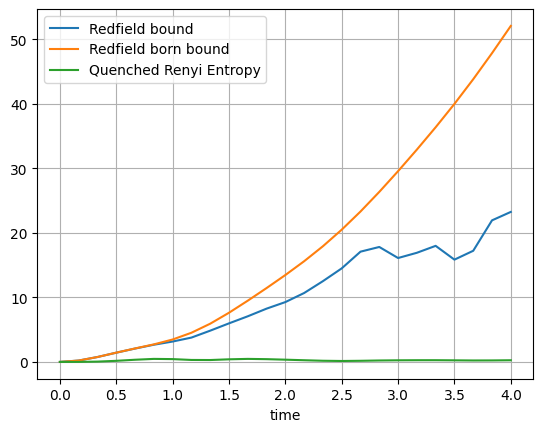

In [40]:
plt.plot(tlist,2*np.array(bound), label='Redfield bound')
plt.plot(tlist,2*np.array(born_bound), label='Redfield born bound')
plt.plot(tlist, renyi_entropy,label = 'Quenched Renyi Entropy')
plt.xlabel('time')

plt.legend()
#plt.savefig('QSL spin chain.pdf')
plt.grid()
plt.show()


Here, we construct the Liouvillian superoerator

$$
\mathcal{H}(t) = -J^{2} \int_{0}^{t} ds \Bigg[ 
\Gamma(t,s) \Big( \sigma_{1}^{z}(t) \sigma_{1}^{z}(s) \otimes I - \sigma_{1}^{z}(s) \otimes \sigma_{1}^{z}(t) \Big) 
+ \Gamma(t,s)^{*} \Big( I \otimes \sigma_{1}^{z}(s) \sigma_{1}^{z}(t) - \sigma_{1}^{z}(t) \otimes \sigma_{1}^{z}(s) \Big) 
\Bigg]
$$


In [28]:

def liouv_superop(t1, t2, J, HB, HS, rho, A, B):
    # Heisenberg time evolution of sigmaz at times t1 and t2
    sigz_t1 = heisenberg_time_evolution(HS, sigmaz(), t1)
    sigz_t2 = heisenberg_time_evolution(HS, sigmaz(), t2)
    
    # Bath correlation function
    bath_corr = twopt_2t(HB, rho, A, B, t1, t2)
    
    # Construct the superoperators
    superop1 = -(J**2) * bath_corr * (tensor(sigz_t1 * sigz_t2, qeye(2)) + tensor(sigz_t2, sigz_t1))
    superop2 = -(J**2) * np.conj(bath_corr) * (tensor(qeye(2), sigz_t2 * sigz_t1) + tensor(sigz_t1, sigz_t2))
    
    # Combine the superoperators
    superop = superop1 + superop2
    fin_superop = superop - superop.dag()  # Final superoperator minus its adjoint
    
    return fin_superop.full()



$$
S_{A}^{2}(t)\leq \int dt  \left\lVert \mathcal{H}(t) - \mathcal{H}(t)^{\dagger} \right\rVert
$$
 

In [29]:


def redfield_spec_bound(t, J, H_bath, H_self, init_state, A, B):
    # Integrate liouv_superop with respect to x, then take the spectral norm, then integrate with respect to y
    def inner_integral(y):
        # Integrate liouv_superop with respect to x from 0 to y
        def integrand(x):
            return liouv_superop(y, x, J, H_bath, H_self, init_state, A, B)
        
        # Using quad_vec with specified tolerances for matrix-valued output
        integrated_superop, _ = integrate.quad_vec(integrand, 0, y, epsabs=1e-6, epsrel=1e-6)
        
        # Calculate spectral norm with np.linalg.norm (2-norm) and handle any small negative values
        spectral_norm = np.linalg.norm(integrated_superop, ord=2)
        return spectral_norm
    
    # Integrate the spectral norm over the outer bound with respect to y from 0 to t, with tolerances
    result, _ = integrate.quad(inner_integral, 0, t, epsabs=1e-6, epsrel=1e-6)
    return result

In [ ]:
spec_bound = []
spec_born_bound = []
H_sys = -h * sigmax() -g * sigmaz()

# Iterate over time list and calculate spectral bounds
for i in range(len(tlist)):
    rho_t = result.states[i]
    t = tlist[i]
    
    # Partial trace to obtain reduced bath state
    rho_bath = ptrace(rho_t, [i for i in range(1, N)])
    
    # Calculate Redfield spectral bound
    red_bound = redfield_spec_bound(t, J, H_rest, H_sys, rho_bath, bath_op, bath_op)
    red_born_bound = redfield_spec_bound(t, J, H_rest, H_sys, thermal_state_rest, bath_op, bath_op)
    print(i)
    
    spec_bound.append(red_bound)
    spec_born_bound.append(red_born_bound)

    

    
# Plotting the Redfield spectral bound and Renyi entropy







0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Plot saved as: N=4_TFIM_h=2.1_J=1.0_g=1.1_lsb_renyi.pdf


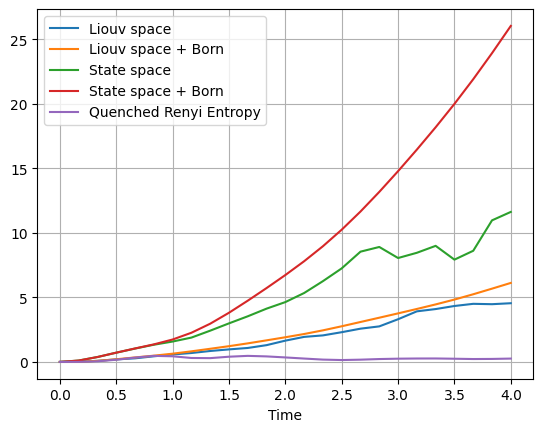

In [37]:
plt.plot(tlist, spec_bound, label='Liouv space')
plt.plot(tlist, spec_born_bound, label='Liouv space + Born')
plt.plot(tlist,bound, label='State space')
plt.plot(tlist,born_bound, label='State space + Born')
#plt.plot(tlist, bound, label='Spectral norm bound')
#plt.plot(tlist, tr_norm_bound, label='Trace norm bound')
plt.plot(tlist, renyi_entropy, label='Quenched Renyi Entropy')
plt.xlabel('Time')
#plt.title('QSL for $H = J\\sum_{i}\\sigma_{i}^{z}\\sigma_{i+1}^{z} + h\\sum_{i}\\sigma_{i}^{x}$ with $N=4, J=1.0, h=1.3, \\beta=1.0$')
plt.legend()
plt.grid()
filename = f"N={N}_TFIM_h={h}_J={J}_g={g}_lsb_renyi.pdf"
plt.savefig(filename)

print(f"Plot saved as: {filename}")

Plot saved as: N=4_TFIM_h=2.1_J=1.0_g=1.1_lsb_otoc.pdf


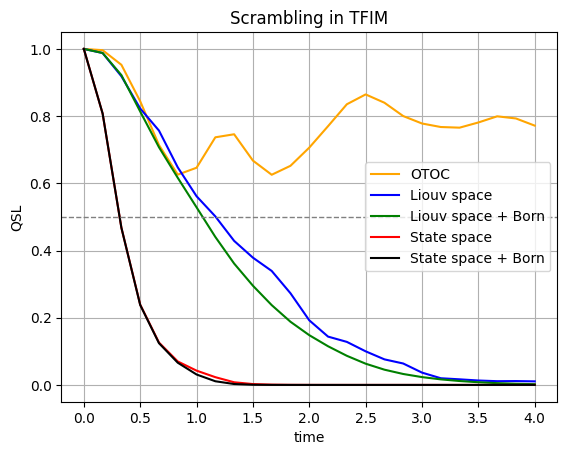

In [39]:
bound1=[]
bound2=[]
bound3=[]
bound4=[]
bound5=[]

for b in bound:
    bound1.append(np.exp(-2*b))
    
for b in born_bound:
    bound5.append(np.exp(-2*b))
    
for b in spec_bound:
    bound2.append(np.exp(-b))
    
for b in renyi_entropy:
    bound3.append(np.exp(-b))

for b in spec_born_bound:
    bound4.append(np.exp(-b))
    
#plt.plot(tlist,bound1, label='Spectral bound')
plt.plot(tlist, bound3,label = 'OTOC', color = 'orange')
plt.plot(tlist, bound2,label = 'Liouv space', color='blue')

plt.plot(tlist, bound4,label = 'Liouv space + Born', color='green')

plt.plot(tlist, bound1,label = 'State space', color = 'Red')
plt.plot(tlist, bound5,label = 'State space + Born', color = 'Black')
plt.axhline(y=0.5 ,color='gray', linestyle='--', linewidth=1)

plt.ylabel('QSL')
plt.xlabel('time')
plt.title('Scrambling in TFIM')
plt.grid()
plt.legend()
#plt.title('QSL for $H = J\\sum_{i}\\sigma_{i}^{z}\\sigma_{i+1}^{z} + h\\sum_{i}\\sigma_{i}^{x}$ with $N=4, J=1.0, h=1.3, \\beta=1.0$')
filename = f"N={N}_TFIM_h={h}_J={J}_g={g}_lsb_otoc.pdf"
plt.savefig(filename)

print(f"Plot saved as: {filename}")




